In [1]:
import pandas as pd
from statistics import mean, stdev 

# Load and Prepare data

In [2]:
merchant_train = pd.read_csv('../data/curated/final_model/agg_fortnightly_mean_sd_marketcorr_train_NOFRAUD.csv')
merchant_validate = pd.read_csv('../data/curated/final_model/agg_fortnightly_mean_sd_marketcorr_validate_NOFRAUD.csv')
merchant_overall = pd.read_csv('../data/curated/final_model/agg_fortnightly_mean_sd_marketcorr_NOFRAUD.csv')

merchant_fortnight_train = pd.read_csv('../data/curated/final_model/fortnightly_agg_merchant_transactions_train_NOFRAUD.csv')
merchant_fortnight_validate = pd.read_csv('../data/curated/final_model/fortnightly_agg_merchant_transactions_validate_NOFRAUD.csv')
merchant_fortnight= pd.read_csv('../data/curated/final_model/fortnightly_agg_merchant_transactions_NOFRAUD.csv')

In [3]:
loyalty_train = pd.read_csv('../data/curated/final_model/loyalty_train.csv')
loyalty_train = loyalty_train[['merchant_abn', 'repeated_purchase_rate']]

loyalty_overall = pd.read_csv(('../data/curated/final_model/loyalty_full.csv'))
loyalty_overall = loyalty_train[['merchant_abn', 'repeated_purchase_rate']]

In [4]:
persona_train = pd.read_csv('../data/curated/final_model/persona_train.csv')

persona_overall = pd.read_csv(('../data/curated/final_model/persona_full.csv'))

In [5]:
growth_train = pd.read_csv('../data/curated/final_model/E(r)_train.csv')

growth_overall = pd.read_csv('../data/curated/final_model/E(r)_final.csv')

In [6]:
# merge dataset with 4th to 6th variable
merchant_train = merchant_train.merge(growth_train, on='merchant_abn', how='inner')
merchant_train = merchant_train.merge(loyalty_train, on='merchant_abn', how='inner')
merchant_train = merchant_train.merge(persona_train, on='merchant_abn', how='inner')

merchant_train

,merchant_abn,mean,stdev,n_periods,corr,covar,beta,weighted E(r),repeated_purchase_rate,persona_score
0,10023283211,70749.673866,18636.265281,23,0.924841,2.089959e+11,0.001421,-0.323900,0.036760,0.003602
1,10142254217,22397.234199,7661.654456,23,0.848513,7.883019e+10,0.000536,-0.380866,0.041188,0.004071
2,10187291046,6739.845784,3296.685077,23,0.356489,1.425068e+10,0.000097,-0.589436,0.000000,0.003787
3,10192359162,41976.201423,19772.703184,23,0.503911,1.208179e+11,0.000822,-0.551896,0.000000,0.005775
4,10206519221,90606.920640,25122.144347,23,0.945070,2.878939e+11,0.001958,-0.383000,0.107863,0.003607
...,...,...,...,...,...,...,...,...,...,...
4339,99938978285,106653.055688,25983.036269,23,0.978122,3.081731e+11,0.002096,-0.395115,0.175840,0.003789
4340,99974311662,6155.721098,3952.631998,23,0.301563,1.445361e+10,0.000098,-0.351165,0.000000,0.003838
4341,99976658299,877875.375777,223217.077839,23,0.983820,2.662900e+12,0.018111,-0.391975,0.231100,0.003747
4342,99987905597,13342.109019,7503.391891,23,0.349577,3.180625e+10,0.000216,-0.378324,0.000000,0.001920


In [7]:
merchant_train.describe()

,merchant_abn,mean,stdev,n_periods,corr,covar,beta,weighted E(r),repeated_purchase_rate,persona_score
count,4.344000e+03,4.344000e+03,4344.000000,4344.000000,4295.000000,4.295000e+03,4295.000000,4344.000000,4344.000000,4344.000000
mean,5.471355e+10,9.997206e+04,31931.351240,22.343692,0.534169,3.013706e+11,0.002050,-0.308450,0.028709,0.004312
std,2.594273e+10,2.390322e+05,59617.599173,2.212615,0.398175,7.091202e+11,0.004823,1.834591,0.081238,0.006134
min,1.002328e+10,2.665122e+02,693.015485,3.000000,-1.000000,-3.171614e+11,-0.002157,-0.621248,0.000000,0.000000
25%,3.193214e+10,6.676722e+03,5592.659720,23.000000,0.295828,1.674197e+10,0.000114,-0.394782,0.000000,0.003103
50%,5.483252e+10,2.359680e+04,13487.074419,23.000000,0.619372,7.973185e+10,0.000542,-0.388627,0.004040,0.003750
75%,7.672848e+10,1.040795e+05,36499.124237,23.000000,0.869536,3.268883e+11,0.002223,-0.367884,0.020814,0.004273
max,9.999054e+10,2.429041e+06,643948.554260,23.000000,1.000000,7.429117e+12,0.050526,102.090732,0.987563,0.212823


In [8]:
merchant_train['corr'] = merchant_train['corr'] * 100000
merchant_train['weighted E(r)'] = merchant_train['weighted E(r)'] * 100000
merchant_train['repeated_purchase_rate'] = merchant_train['repeated_purchase_rate'] * 1000000
merchant_train['persona_score'] = merchant_train['persona_score'] * 10000000

In [9]:
merchant_train.describe()

,merchant_abn,mean,stdev,n_periods,corr,covar,beta,weighted E(r),repeated_purchase_rate,persona_score
count,4.344000e+03,4.344000e+03,4344.000000,4344.000000,4295.000000,4.295000e+03,4295.000000,4.344000e+03,4344.000000,4.344000e+03
mean,5.471355e+10,9.997206e+04,31931.351240,22.343692,53416.858494,3.013706e+11,0.002050,-3.084496e+04,28709.276798,4.311539e+04
std,2.594273e+10,2.390322e+05,59617.599173,2.212615,39817.521039,7.091202e+11,0.004823,1.834591e+05,81238.037184,6.133957e+04
min,1.002328e+10,2.665122e+02,693.015485,3.000000,-100000.000000,-3.171614e+11,-0.002157,-6.212476e+04,0.000000,0.000000e+00
25%,3.193214e+10,6.676722e+03,5592.659720,23.000000,29582.827156,1.674197e+10,0.000114,-3.947816e+04,0.000000,3.103131e+04
50%,5.483252e+10,2.359680e+04,13487.074419,23.000000,61937.207234,7.973185e+10,0.000542,-3.886265e+04,4040.420530,3.750275e+04
75%,7.672848e+10,1.040795e+05,36499.124237,23.000000,86953.596674,3.268883e+11,0.002223,-3.678837e+04,20814.208486,4.273354e+04
max,9.999054e+10,2.429041e+06,643948.554260,23.000000,100000.000000,7.429117e+12,0.050526,1.020907e+07,987563.430663,2.128228e+06


In [10]:
# merge dataset with 4th variable
merchant_overall = merchant_overall.merge(growth_overall, on='merchant_abn', how='inner')
merchant_overall = merchant_overall.merge(loyalty_overall, on='merchant_abn', how='inner')
merchant_overall = merchant_overall.merge(persona_overall, on='merchant_abn', how='inner')

merchant_overall

,merchant_abn,mean,stdev,n_periods,corr,covar,beta,weighted E(r),repeated_purchase_rate,persona_score
0,10023283211,71944.954088,15268.757666,38,0.898658,1.663833e+11,0.001132,-0.506826,0.036760,0.004553
1,10142254217,22687.034837,6496.702667,38,0.801093,6.310849e+10,0.000429,-0.523320,0.041188,0.004740
2,10187291046,6831.716274,3379.999688,38,0.349956,1.434304e+10,0.000098,-0.374233,0.000000,0.004666
3,10192359162,40955.314495,17639.407542,38,0.472340,1.010300e+11,0.000687,-0.539180,0.000000,0.006020
4,10206519221,88038.400673,21292.527062,38,0.921726,2.379801e+11,0.001619,-0.506193,0.107863,0.004468
...,...,...,...,...,...,...,...,...,...,...
4343,99938978285,106551.591313,21699.148448,38,0.959032,2.523407e+11,0.001716,-0.539419,0.175840,0.004735
4344,99974311662,6326.735554,4783.350900,38,0.169271,9.818105e+09,0.000067,-0.393847,0.000000,0.006811
4345,99976658299,871306.137224,186985.910229,38,0.978855,2.219417e+12,0.015094,-0.531831,0.231100,0.004723
4346,99987905597,16290.096561,10052.773545,38,0.258865,3.155515e+10,0.000215,-0.357825,0.000000,0.003205


In [11]:
merchant_overall['corr'] = merchant_overall['corr'] * 100000
merchant_overall['weighted E(r)'] = merchant_overall['weighted E(r)'] * 100000
merchant_overall['repeated_purchase_rate'] = merchant_overall['repeated_purchase_rate'] * 1000000
merchant_overall['persona_score'] = merchant_overall['persona_score'] * 10000000

In [8]:
merchant_overall['corr'] = merchant_overall['corr'] * 1000000

# Define functions

First write function that gets scores of all stores

In [12]:
# sometimes std/covar has nan values, fill them with 0
merchant_overall = merchant_overall.fillna(0)
merchant_train = merchant_train.fillna(0)
merchant_validate = merchant_validate.fillna(0)

a_combo = [1, 1, 1, 1, 1, 1]

In [13]:
def get_hscore(merchant_train, a_combo, k):
    # helper function to get the score for a company using h value input
    VARNAME = ['mean', 'stdev', 'corr', 'weighted E(r)', 'repeated_purchase_rate', 'persona_score']

    merchant_train['score'] = a_combo[0] * merchant_train[VARNAME[0]]

    for i in range(1, k):
        merchant_train['score'] = merchant_train['score'] + a_combo[i] * merchant_train[VARNAME[i]]
    
    return merchant_train[['merchant_abn', 'score']]

In [14]:
# testrun of helper function
merchants_train_score = get_hscore(merchant_train, a_combo, 6)
merchants_train_score

,merchant_abn,score
0,10023283211,2.222606e+05
1,10142254217,1.587200e+05
2,10187291046,2.461100e+04
3,10192359162,1.147020e+05
4,10206519221,3.158652e+05
...,...,...
4339,99938978285,4.046628e+05
4340,99974311662,4.353308e+04
4341,99976658299,1.428849e+06
4342,99987905597,3.717099e+04


Get top 100 and make into portfolio (just a list)

In [15]:
def get_portfolio_abn(merchants_train_score):
    # get the top 100 merchant's abn
    
    sorted_merchants_train_score = merchants_train_score.sort_values(['score'], ascending=False)

    top_100_portfolio = sorted_merchants_train_score.head(100)

    top_portfolio_merchants = list(top_100_portfolio['merchant_abn'])

    return top_portfolio_merchants

In [16]:
# testrun the function
top_portfolio_merchants = get_portfolio_abn(merchants_train_score)
# top_portfolio_merchants

Get Portfolio Stats (load periodic data and add up)

- get portfolio fortnightly E[r] and sd(r) after summing up portfolio transactions for each fortnight and take mean(), std()
- calculate E(r) / sd(r)

In [17]:
def get_sharpe_ratio_of_portfolio(merchant_fortnight_validate, top_portfolio_merchants):
    # calculate the sharpe ratio using the validate

    top_100_portfolio_fortnightly = pd.DataFrame()

    for abn in top_portfolio_merchants:
        tmp = merchant_fortnight_validate[merchant_fortnight_validate['merchant_abn'] == abn]
        top_100_portfolio_fortnightly = pd.concat([top_100_portfolio_fortnightly, tmp])

    top_100_portfolio_fortnightly_agg = top_100_portfolio_fortnightly.groupby(['Year', 'Fortnight']).agg({'sum_transactions': mean})

    top_100_portfolio_fortnightly_mean = mean(top_100_portfolio_fortnightly_agg['sum_transactions'])
    top_100_portfolio_fortnightly_sd = stdev(top_100_portfolio_fortnightly_agg['sum_transactions'])

    portfolio_sharpe_ratio = top_100_portfolio_fortnightly_mean/top_100_portfolio_fortnightly_sd
    
    return portfolio_sharpe_ratio

In [18]:
# testrun the function
portfolio_sharpe_ratio = get_sharpe_ratio_of_portfolio(merchant_fortnight_validate, top_portfolio_merchants)
portfolio_sharpe_ratio

8.785756234209185

# Run Test

In [21]:
from YangZhou.GuidanceAlgorithm import *
from YangZhou.CruiseEngine import *
from YangZhou.CruiseAlgorithm import *

In [22]:
# Set values to try in each hyperparameter value

# arguments = {
#     "a1": {1: -10000, 2: -100, 3: -10, 4: -1, 5: -0.1, 6: -0.01, 7:-0.001, 8:0, 9:0.001, 10:0.01, 11:0.1, 12:1, 13:10, 14:100, 15:1000, 16:10000},
#     "a2": {1: -10000, 2: -100, 3: -10, 4: -1, 5: -0.1, 6: -0.01, 7:-0.001, 8:0, 9:0.001, 10:0.01, 11:0.1, 12:1, 13:10, 14:100, 15:1000, 16:10000},
#     "a3": {1: -10000, 2: -100, 3: -10, 4: -1, 5: -0.1, 6: -0.01, 7:-0.001, 8:0, 9:0.001, 10:0.01, 11:0.1, 12:1, 13:10, 14:100, 15:1000, 16:10000},
#     "a4": {1: -10000, 2: -100, 3: -10, 4: -1, 5: -0.1, 6: -0.01, 7:-0.001, 8:0, 9:0.001, 10:0.01, 11:0.1, 12:1, 13:10, 14:100, 15:1000, 16:10000}
# }

arguments = {
    "a1": {1: -10000, 2: -100, 3: -1, 4: -0.01, 5: -0.0001, 6: 0.0001, 7:0.01, 8:1, 9:100, 10:10000},
    "a2": {1: -10000, 2: -100, 3: -1, 4: -0.01, 5: -0.0001, 6: 0.0001, 7:0.01, 8:1, 9:100, 10:10000},
    "a3": {1: -10000, 2: -100, 3: -1, 4: -0.01, 5: -0.001, 6: 0.0001, 7:0.01, 8:1, 9:100, 10:10000},
    "a4": {1: -10000, 2: -100, 3: -1, 4: -0.01, 5: -0.001, 6: 0.0001, 7:0.01, 8:1, 9:100, 10:10000},
    "a5": {1: -10000, 2: -100, 3: -1, 4: -0.01, 5: -0.001, 6: 0.0001, 7:0.01, 8:1, 9:100, 10:10000},
    "a6": {1: -10000, 2: -100, 3: -1, 4: -0.01, 5: -0.001, 6: 0.0001, 7:0.01, 8:1, 9:100, 10:10000}
}
arguments

{'a1': {1: -10000,
  2: -100,
  3: -1,
  4: -0.01,
  5: -0.0001,
  6: 0.0001,
  7: 0.01,
  8: 1,
  9: 100,
  10: 10000},
 'a2': {1: -10000,
  2: -100,
  3: -1,
  4: -0.01,
  5: -0.0001,
  6: 0.0001,
  7: 0.01,
  8: 1,
  9: 100,
  10: 10000},
 'a3': {1: -10000,
  2: -100,
  3: -1,
  4: -0.01,
  5: -0.001,
  6: 0.0001,
  7: 0.01,
  8: 1,
  9: 100,
  10: 10000},
 'a4': {1: -10000,
  2: -100,
  3: -1,
  4: -0.01,
  5: -0.001,
  6: 0.0001,
  7: 0.01,
  8: 1,
  9: 100,
  10: 10000},
 'a5': {1: -10000,
  2: -100,
  3: -1,
  4: -0.01,
  5: -0.001,
  6: 0.0001,
  7: 0.01,
  8: 1,
  9: 100,
  10: 10000},
 'a6': {1: -10000,
  2: -100,
  3: -1,
  4: -0.01,
  5: -0.001,
  6: 0.0001,
  7: 0.01,
  8: 1,
  9: 100,
  10: 10000}}

In [18]:
# num_arg_vals = [len(arguments[i]) for i in arguments]
# num_arg_vals

YangZhou Algorithm

In [23]:
def get_new_cores(core, num_arg_val, surrounding_vectors, found, checked_boxes,
                  checked_core, merchant_train, merchant_fortnight_validate, arguments, tuning_results):

    # if (should be rare) case where core has been a core before, then skip. For prevention of infinite loops
    if checked_core[flatten_coordinates_h(core, num_arg_val)] == 2:
        prev_checked = 1
    else:
        checked_core[flatten_coordinates_h(core, num_arg_val)] = 2
        prev_checked = 0

    if prev_checked:
        print('Prev checked:', core, '!\n')
        return [], found, checked_boxes, checked_core, tuning_results

    # prepare data for welch test
    surrounding_coordinates = get_surrounding_coordinates(core,
                                            surrounding_vectors, num_arg_val)

    indices = get_indices(core)

    # put coordinates into treatments and nulls
    treatment, null, direction = get_blocks(core, surrounding_coordinates,
                                            surrounding_vectors, indices, num_arg_val)

    # actually tune the surrounding coordinates
    for coord in surrounding_coordinates:
        #TODO: TRAIN AND TEST
        index = flatten_coordinates_h(coord, num_arg_val)
        if checked_boxes[index] == 0:
            val_accu, tuning_results = train_and_get_accuracies(arguments,
                                            coord, merchant_train, merchant_fortnight_validate, tuning_results)

            found[index] = val_accu
            checked_boxes[index] = 1

    # perform welch test and return surrounding coordinates that should be used as new core
    new_cores = find_new_core1(treatment, null, direction, num_arg_val, found)

    return new_cores, found, checked_boxes, checked_core, tuning_results

In [24]:
def YangZhou_GuidanceSystem(core, num_arg_val, surrounding_vectors, found,
                            checked_boxes, restarts, checked_core, been_best,
                            merchant_train, merchant_fortnight_validate, arguments, tuning_results):

    if restarts == 0:
        print("BEGIN INITIAL GUIDANCE\n")
    else:
        print("RESTART GUIDANCE: ROUND", restarts, '\n')

    print('ROUND', restarts, 'ITERATION: ', 0, '\n')

    # first get a surrounding 3^d tuned
    new_cores, found, checked_boxes, checked_core, tuning_results = get_new_cores(core,
                                                num_arg_val, surrounding_vectors, found,
                                                checked_boxes, checked_core, merchant_train, merchant_fortnight_validate,
                                                arguments, tuning_results)
    for new_core in new_cores: # only add if not checked before
        if checked_core[flatten_coordinates_h(new_core, num_arg_val)] == 0:
            checked_core[flatten_coordinates_h(new_core, num_arg_val)] = 1

    round = 1
    while new_cores: # while new cores are being added
        print('ROUND', restarts, "ITERATION: ", round, "\n")
        round += 1

        print('New cores:', new_cores, '\n')
        old_new_cores = deepcopy(new_cores)
        new_cores = list()

        # for each of the new cores, 'recursively' tune and grab new cores;
        # but each Iteration doesn't end until all cores of current round has been checked
        for new_core in old_new_cores:

            new_new_cores, found, checked_boxes, checked_core, tuning_results = get_new_cores(new_core,
                                                    num_arg_val, surrounding_vectors, found, checked_boxes,
                                                    checked_core, merchant_train, merchant_fortnight_validate, 
                                                    arguments, tuning_results)

            for new_new_core in new_new_cores:
                if checked_core[flatten_coordinates_h(new_new_core, num_arg_val)] == 0:
                    new_cores.append(new_new_core)
                    checked_core[flatten_coordinates_h(new_new_core, num_arg_val)] = 1

    # for current max, get 3^d block. if new max happens to be found, continue to do 3^d block until no new max is found
    # just a cheap way to flesh out the max (the goal of YangZhou)
    max_combo = recreate_coordinates_h(np.argmax(found), num_arg_val)

    while been_best[flatten_coordinates_h((max_combo), num_arg_val)] == 0:

        been_best[flatten_coordinates_h((max_combo), num_arg_val)] = 1
        #add surrounding find!! ##functionalise
        surrounding_coordinates = get_surrounding_coordinates(max_combo, surrounding_vectors, num_arg_val)
        for coord in surrounding_coordinates:
            #TODO: TRAIN AND TEST
            index = flatten_coordinates_h(coord, num_arg_val)
            if checked_boxes[index] == 0:

                val_accu, tuning_results = train_and_get_accuracies(arguments, coord, 
                                merchant_train, merchant_fortnight_validate, tuning_results)

                found[index] = val_accu
                checked_boxes[index] = 1

        max_combo = recreate_coordinates_h(np.argmax(found),num_arg_val)

    max_accuracy = max(found)

    # print information of this round
    if restarts == 0:
        print(f"\nYANGZHOU INITIAL GUIDE STAGE ENDED\n")
    else:
        print(f"\nYANGZHOU GUIDE STAGE {restarts} ENDED\n")


    if len(arguments) == 2:
        print('Found: \n', np.array(found).reshape(num_arg_val).round(4), '\n')
        print('Checked Boxes: \n', np.array(checked_boxes).reshape(num_arg_val).round(4), '\n')

    print('Max Accuracy From This Guidance Round: \n', max(found))
    print('Max Combo From This Guidance Round: \n', max_combo)

    print('% Combos Checked Thus Far:', int(sum(checked_boxes)), 'out of', cond_prod(num_arg_val),
          'which is', f'{np.mean(checked_boxes).round(8)*100}%')


    return max_combo, max_accuracy, found, checked_boxes, checked_core, been_best, tuning_results

In [25]:
def YangZhou_CruiseSystem(arguments, num_arg, num_arg_val, surrounding_vectors, max_combo,
                          max_accuracy, found, checked_boxes, restarts, checked_core, merchant_train, merchant_fortnight_validate,
                          tuning_results):

    print(f"BEGIN CRUISING: ROUND {restarts}\n")

    # get cruise coordinates in sorted order (furthest away from current max)
    sorted_cruise_coordinates = get_sorted_cruise_coordinates(arguments, num_arg, max_combo)

    # calculate warning threshold
    max_surrounding_mean, max_surrounding_sd = get_max_surrounding_mean_sd(max_combo,
                                                max_accuracy, surrounding_vectors, num_arg_val, found)

    #TODO: add parameter to specify which warning_threshold

    # warning_threshold = cruise_warning_threshold1(max_accuracy, max_surrounding_sd, len(surrounding_vectors)-1)
    warning_threshold = cruise_warning_threshold2(max_accuracy, max_surrounding_sd, len(surrounding_vectors)-1)
    # warning_threshold = cruise_warning_threshold3(max_surrounding_mean, max_surrounding_sd, len(surrounding_vectors)-1)
    # warning_threshold = cruise_warning_threshold4(max_surrounding_mean, max_surrounding_sd, len(surrounding_vectors)-1)

    # check each cruise coordinate
    for cruise_coord in sorted_cruise_coordinates:
        index = flatten_coordinates_h(cruise_coord, num_arg_val)

        # only search if it hasn't been checked before (if has then is not an artifect of significance)
        if not checked_boxes[index]:
            val_accu, tuning_results = train_and_get_accuracies(arguments, cruise_coord,
                                                    merchant_train, merchant_fortnight_validate, tuning_results)

            found[index] = val_accu
            checked_boxes[index] = 1

            # if above warning threshold, then stop cruise and restart guide
            if found[index] >= warning_threshold:
                if len(arguments) == 2:
                    print('Found: \n', np.array(found).reshape(num_arg_val).round(4), '\n')
                    print('Checked Boxes: \n', np.array(checked_boxes).reshape(num_arg_val).round(4), '\n')

                print('Max Accuracy From This Guidance Round: \n', max(found))
                print('Max Combo From This Guidance Round: \n', max_combo)

                print('% Combos Checked Thus Far:', int(sum(checked_boxes)), 'out of',
                      cond_prod(num_arg_val), 'which is', f'{np.mean(checked_boxes).round(8)*100}%')

                print(f"YANGZHOU CRUISE STAGE {restarts} ENDED, RESTARTING GUIDANCE\n")
                return 1, cruise_coord, found, checked_boxes, checked_core, tuning_results

    # if reach here then all cruise indicies checked. can safely say end cruise
    print(f"YANGZHOU CRUISE STAGE {restarts} ENDED\n")
    print(f"YANGZHOU CRUISE SYSTEM SHUTDOWN\n\n")

    return 0, [], found, checked_boxes, checked_core, tuning_results

In [26]:
def YangZhou_CruiseSystem(arguments, num_arg, num_arg_val, surrounding_vectors, max_combo,
                          max_accuracy, found, checked_boxes, restarts, checked_core, merchant_train, merchant_fortnight_validate,
                           tuning_results):

    print(f"BEGIN CRUISING: ROUND {restarts}\n")

    # get cruise coordinates in sorted order (furthest away from current max)
    sorted_cruise_coordinates = get_sorted_cruise_coordinates(arguments, num_arg, max_combo)

    # calculate warning threshold
    max_surrounding_mean, max_surrounding_sd = get_max_surrounding_mean_sd(max_combo,
                                                max_accuracy, surrounding_vectors, num_arg_val, found)

    #TODO: add parameter to specify which warning_threshold

    # warning_threshold = cruise_warning_threshold1(max_accuracy, max_surrounding_sd, len(surrounding_vectors)-1)
    warning_threshold = cruise_warning_threshold2(max_accuracy, max_surrounding_sd, len(surrounding_vectors)-1)
    # warning_threshold = cruise_warning_threshold3(max_surrounding_mean, max_surrounding_sd, len(surrounding_vectors)-1)
    # warning_threshold = cruise_warning_threshold4(max_surrounding_mean, max_surrounding_sd, len(surrounding_vectors)-1)

    # check each cruise coordinate
    for cruise_coord in sorted_cruise_coordinates:
        index = flatten_coordinates_h(cruise_coord, num_arg_val)

        # only search if it hasn't been checked before (if has then is not an artifect of significance)
        if not checked_boxes[index]:
            val_accu, tuning_results = train_and_get_accuracies(arguments, cruise_coord,
                                                    merchant_train, merchant_fortnight_validate, tuning_results)

            found[index] = val_accu
            checked_boxes[index] = 1

            # if above warning threshold, then stop cruise and restart guide
            if found[index] >= warning_threshold:
                if len(arguments) == 2:
                    print('Found: \n', np.array(found).reshape(num_arg_val).round(4), '\n')
                    print('Checked Boxes: \n', np.array(checked_boxes).reshape(num_arg_val).round(4), '\n')

                print('Max Accuracy From This Guidance Round: \n', max(found))
                print('Max Combo From This Guidance Round: \n', max_combo)

                print('% Combos Checked Thus Far:', int(sum(checked_boxes)), 'out of',
                      cond_prod(num_arg_val), 'which is', f'{np.mean(checked_boxes).round(8)*100}%')

                print(f"YANGZHOU CRUISE STAGE {restarts} ENDED, RESTARTING GUIDANCE\n")
                return 1, cruise_coord, found, checked_boxes, checked_core, tuning_results

    # if reach here then all cruise indicies checked. can safely say end cruise
    print(f"YANGZHOU CRUISE STAGE {restarts} ENDED\n")
    print(f"YANGZHOU CRUISE SYSTEM SHUTDOWN\n\n")

    return 0, [], found, checked_boxes, checked_core, tuning_results

In [1]:
def train_and_get_accuracies(arguments, coord, merchant_train, merchant_fortnight_validate, tuning_results):

    merchants_train_score = get_hscore(merchant_train, [arguments[f'a{i+1}'][coord[i]] for i in range(6)], 6)
    top_portfolio_merchants = get_portfolio_abn(merchants_train_score)
    portfolio_sharpe_ratio = get_sharpe_ratio_of_portfolio(merchant_fortnight_validate, top_portfolio_merchants)

    one_result = pd.DataFrame({'a1': [arguments['a1'][coord[0]]],
                               'a2': [arguments['a2'][coord[1]]],
                               'a3': [arguments['a3'][coord[2]]],
                               'a4': [arguments['a4'][coord[3]]],
                               'a5': [arguments['a5'][coord[3]]],
                               'a6': [arguments['a6'][coord[3]]],
                               'portfolio_sharpe_ratio': [portfolio_sharpe_ratio]})

    tuning_results = tuning_results.append(one_result)
    tuning_results.to_csv('../data/tuning/final_model.csv')


    return portfolio_sharpe_ratio, tuning_results

In [28]:
print("YANGZHOU SYSTEM ACTIVATED\n\n")

# Process inputs and initiate arguments
num_arg = {arg:len(arguments[arg]) for arg in arguments}
num_arg_val = list(num_arg.values())

arg_median_values = {arg:(num_arg[arg]//2)+1 for arg in arguments}
core = [arg_median_values[arg] for arg in num_arg]
print('Initial core:', core, '\n')
surrounding_vectors = get_surrounding_vectors(core)

found = np.zeros(np.prod(num_arg_val))
checked_boxes = np.zeros(np.prod(num_arg_val))
checked_core = np.zeros(np.prod(num_arg_val))
been_best = np.zeros(np.prod(num_arg_val))

tuning_results = pd.DataFrame()

print("YANGZHOU GUIDE SYSTEM ACTIVATED\n")

# Initial Round of Guidance
checked_core[flatten_coordinates_h(core, num_arg_val)] = 1
max_combo, max_accuracy, found, checked_boxes, checked_core, been_best, tuning_results = YangZhou_GuidanceSystem(core,
                                                                                num_arg_val, surrounding_vectors, found,
                                                                                checked_boxes, 0, checked_core, been_best,
                                                                                merchant_train, merchant_fortnight_validate, arguments,
                                                                                tuning_results)

# Recursively Cruise and restart Guide if find a combo that is within halfwidth of max
print("YANGZHOU CRUISE SYSTEM ACTIVATED\n")
cruising = 1
restarts = 1
while cruising:
    cruising, restart_core, found, checked_boxes, checked_core, tuning_results = YangZhou_CruiseSystem(arguments,
                                                                                    num_arg, num_arg_val, surrounding_vectors,
                                                                                    max_combo, max_accuracy, found, checked_boxes,
                                                                                    restarts, checked_core, merchant_train, merchant_fortnight_validate, tuning_results)

    if cruising:
        max_combo, max_accuracy, found, checked_boxes, checked_core, been_best, tuning_results = YangZhou_GuidanceSystem(restart_core,
                                                                                    num_arg_val, surrounding_vectors, found, checked_boxes,
                                                                                    restarts, checked_core, been_best, merchant_train, merchant_fortnight_validate, 
                                                                                    arguments, tuning_results)
        restarts += 1

# Final extensive search around maxes.
print("YANGZHOU FINAL GUIDANCE ACTIVATED\n")
old_max_accuracy = deepcopy(max_accuracy)
max_combo, max_accuracy, found, checked_boxes, checked_core, been_best, tuning_results = YangZhou_GuidanceSystem(max_combo,
                                                                                num_arg_val, surrounding_vectors, found,
                                                                                checked_boxes, 'FINAL', checked_core, been_best,
                                                                                merchant_train, merchant_fortnight_validate, arguments, tuning_results)
while(max_accuracy-old_max_accuracy > 0):
    old_max_accuracy = deepcopy(max_accuracy)
    max_combo, max_accuracy, found, checked_boxes, checked_core, tuning_results = YangZhou_GuidanceSystem(max_combo,
                                                                                num_arg_val, surrounding_vectors, found, checked_boxes,
                                                                                'FINAL', checked_core, been_best, merchant_train, merchant_fortnight_validate,
                                                                                 arguments, tuning_results)


# Display final information
print("YANGZHOU FINAL GUIDANCE STAGE ENDED")
print("YANGZHOU MISSION ACCOMPLISHED\n")

if len(arguments) == 2:
    print('Final Found: \n', np.array(found).reshape(num_arg_val).round(4), '\n')
    print('Final Checked Boxes: \n', np.array(checked_boxes).reshape(num_arg_val).round(4), '\n')
    print('Final Checked Cores: \n', np.array(checked_core).reshape(num_arg_val).round(4), '\n')

print('Max Accuracy: \n', max(found))
print('Max Combo: \n', max_combo)

print('% Combos Checked:', int(sum(checked_boxes)), 'out of', cond_prod(num_arg_val),
      'which is', f'{np.mean(checked_boxes).round(8)*100}%')

YANGZHOU SYSTEM ACTIVATED


Initial core: [6, 6, 6, 6, 6, 6] 

YANGZHOU GUIDE SYSTEM ACTIVATED

BEGIN INITIAL GUIDANCE

ROUND 0 ITERATION:  0 

ROUND 0 ITERATION:  1 

New cores: [[7, 7, 5, 7, 5, 5], [5, 6, 7, 6, 5, 5], [5, 5, 5, 7, 5, 5], [5, 6, 7, 6, 6, 6], [6, 6, 5, 7, 6, 6]] 

ROUND 0 ITERATION:  2 

New cores: [[6, 6, 4, 8, 4, 4], [6, 7, 5, 8, 5, 5], [6, 5, 8, 7, 4, 4], [5, 6, 8, 7, 5, 5], [6, 6, 8, 6, 5, 5], [6, 5, 8, 7, 5, 5], [6, 6, 8, 7, 5, 5], [4, 4, 6, 8, 4, 4], [4, 4, 4, 8, 4, 4], [5, 5, 5, 7, 4, 5], [5, 5, 5, 7, 6, 5], [5, 6, 5, 7, 5, 5], [5, 6, 8, 7, 6, 6], [6, 6, 8, 6, 6, 6], [6, 5, 8, 7, 6, 6], [6, 6, 8, 7, 6, 6], [7, 5, 5, 8, 5, 5], [5, 7, 5, 8, 5, 5], [5, 5, 6, 7, 5, 5], [5, 5, 4, 8, 5, 5], [5, 6, 5, 7, 6, 6], [6, 6, 5, 8, 6, 6]] 

ROUND 0 ITERATION:  3 

New cores: [[5, 5, 5, 7, 3, 3], [5, 5, 3, 9, 3, 3], [5, 6, 4, 8, 4, 4], [5, 6, 5, 7, 4, 4], [6, 5, 4, 8, 4, 4], [6, 6, 4, 9, 4, 4], [6, 6, 5, 8, 4, 4], [5, 6, 4, 9, 4, 4], [6, 6, 5, 8, 5, 5], [6, 7, 5, 9, 5, 5], [6, 

KeyboardInterrupt: 

In [20]:
a_combos = []

# a_values = [0.000000001, 0.000001, 0.001, 1, 1000, 1000000, 1000000000, -0.000000001, -0.000001, -0.001, -1, -1000, -1000000, -1000000000]
a_values = [1, 100, 10000, 0.01, 0.0001, -1, -100, -10000, -0.01, -0.0001]


for a1 in a_values:
    # a_combos.append([a1])
    for a2 in a_values:
        # a_combos.append([a1, a2])
        for a3 in a_values:
            # a_combos.append([a1, a2, a3])
            for a4 in a_values:
                # a_combos.append([a1, a2, a3, a4])
                for a5 in a_values:
                    # a_combos.append([a1, a2, a3, a4, a5])
                    for a6 in a_values:
                        a_combos.append([a1, a2, a3, a4, a5, a6])

len(a_combos)
                    

1000000

In [26]:
all_sharpe_ratios = list()

for a_combo in a_combos:
    merchants_train_score = get_hscore(merchant_train, a_combo, 3)

    top_portfolio_merchants = get_portfolio_abn(merchants_train_score)

    portfolio_sharpe_ratio = get_sharpe_ratio_of_portfolio(merchant_fortnight_validate, top_portfolio_merchants)

    all_sharpe_ratios.append(portfolio_sharpe_ratio)

In [27]:
results = pd.DataFrame({'all_combos': a_combos, 'sharpe_ratio': all_sharpe_ratios}).sort_values(['sharpe_ratio'], ascending = False)

# Analyse Results

In [28]:
results.head(60)

,all_combos,sharpe_ratio
929,"[1000, -1, 1000000]",12.656290
507,"[0.001, -1e-06, 1]",12.656290
1126,"[1000000, -1, 1000000000]",12.656290
831,"[1000, 1, 1000000]",12.656290
718,"[1, -0.001, 1000]",12.656290
704,"[1, -1e-06, 1000]",12.656290
1014,"[1000000, 0.001, 1000000000]",12.656290
1140,"[1000000, -1000, 1000000000]",12.656290
901,"[1000, -1e-06, 1000000]",12.656290
1112,"[1000000, -0.001, 1000000000]",12.656290


In [29]:
results.describe()


,sharpe_ratio
count,2744.000000
mean,6.978949
std,3.329562
min,1.674102
25%,3.819442
50%,8.364021
75%,8.648205
max,12.656290


array([[<AxesSubplot:title={'center':'sharpe_ratio'}>]], dtype=object)

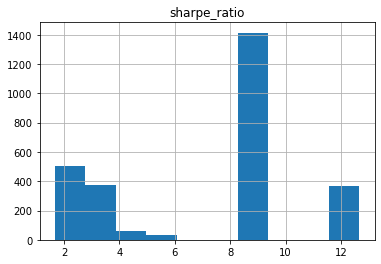

In [30]:
results.hist()

In [31]:
results.to_csv('../data/curated/final_model/3_vars.csv', index=False)

# Get best combination

In [32]:
final_a_combo = []

In [33]:
merchants_overall_score = get_hscore(merchant_overall, final_a_combo, 4)

final_top_portfolio_merchants = get_portfolio_abn(merchants_overall_score)

IndexError: list index out of range

By cluster

In [ ]:
portfolio_sharpe_ratio = get_sharpe_ratio_of_portfolio(merchant_overall, final_top_portfolio_merchants)

# By cluster

In [ ]:
clusters = pd.read_csv('../data/curated/clusters/merchant_clusters.csv')

In [ ]:
clusters